# Deep Learning Graduate Course Competition

In [1]:
# !unzip data.zip

**Importing Required Libraries and Functions**

In [10]:
# External Libraries
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Internal Helper ibraries/Functions
from resnet import ResNet
from utils import get_data_loaders, train, test, save_checkpoint, load_checkpoint

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "data"

**Initializing Our Model (implementation [here](resnet.py))**

In [2]:
model = ResNet(num_blocks=[4,4,3]).to(DEVICE)


**Number of Parameters in our Model**

In [4]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 4697742


**Transforms**

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

**Setting Up Data Loaders**

In [5]:
train_loader, test_loader = get_data_loaders(dataset_path=DATA_PATH,batch_size=128,test_transform=test_transform, train_transform=train_transform)

NameError: name 'test_transform' is not defined

**Training Parameters**

In [6]:
start_epoch = 0
end_epoch = 200
loss_function = torch.nn.CrossEntropyLoss()
weight_decay = 0.0005
learning_rate = 0.1
momentum = 0.9
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=end_epoch-start_epoch)

**Loading Checkpoint**

In [7]:
# start_epoch = load_checkpoint(model, optimizer, "checkpoints/my_checkpoint.pth.tar") + 1

**Training**

In [10]:
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

In [11]:
for epoch in range(start_epoch, end_epoch):

  train_loss, train_accuracy = train(model, optimizer, loss_function, train_loader, DEVICE)
  train_loss_history.append(train_loss)
  train_accuracy_history.append(train_accuracy)

  test_loss, test_accuracy = test(model, loss_function, test_loader, DEVICE)
  test_loss_history.append(test_loss)
  test_accuracy_history.append(test_accuracy)

  scheduler.step()

  save_checkpoint(model,optimizer,epoch,"checkpoints/my_checkpoint.pth.tar")

  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}, Train accuracy {train_accuracy}, Test accuracy {test_accuracy}')

Epoch 0, Train loss 1.7045271006386604, Test loss 1.555867543703393, Train accuracy 0.37092, Test accuracy 0.4248
Epoch 1, Train loss 1.2596028037083424, Test loss 1.122639455372774, Train accuracy 0.54214, Test accuracy 0.5953
Epoch 2, Train loss 1.0063763942255084, Test loss 1.1903187979625751, Train accuracy 0.64016, Test accuracy 0.5979
Epoch 3, Train loss 0.860116110433398, Test loss 0.9139165708535835, Train accuracy 0.69644, Test accuracy 0.6796
Epoch 4, Train loss 0.7341962723475893, Test loss 1.2507898128485377, Train accuracy 0.74254, Test accuracy 0.6195
Epoch 5, Train loss 0.6378110122802617, Test loss 0.8185237012331998, Train accuracy 0.77868, Test accuracy 0.726
Epoch 6, Train loss 0.5792490949716105, Test loss 0.6354501575608796, Train accuracy 0.80082, Test accuracy 0.7787
Epoch 7, Train loss 0.5357812981471382, Test loss 0.6568833517877362, Train accuracy 0.81638, Test accuracy 0.7763
Epoch 8, Train loss 0.5062428436925649, Test loss 0.8237194373637815, Train accuracy

KeyboardInterrupt: 

In [9]:
train_loss_history = np.load("plot_files/train_loss_history.npy")
train_accuracy_history = np.load("plot_files/train_accuracy_history.npy")
test_loss_history = np.load("plot_files/test_loss_history.npy")
test_accuracy_history = np.load("plot_files/test_accuracy_history.npy")

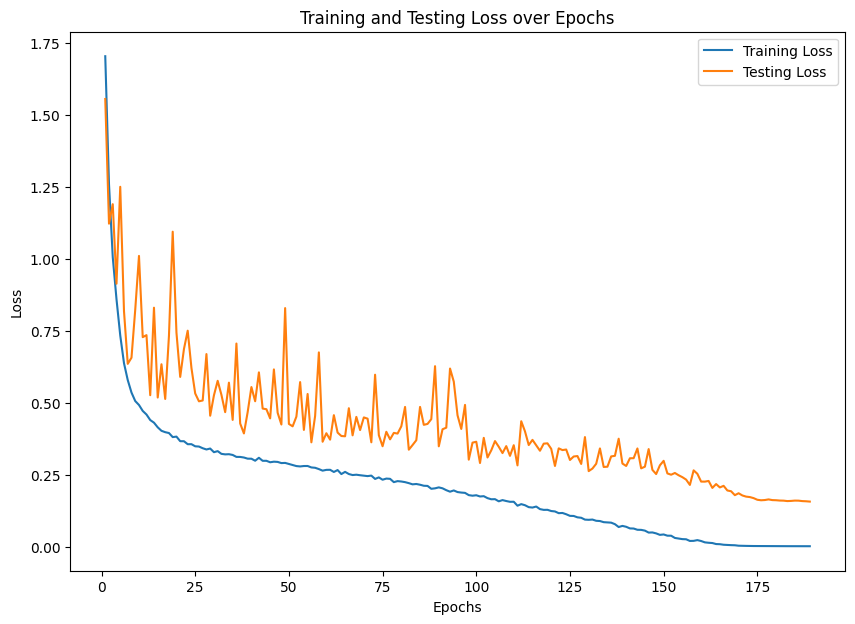

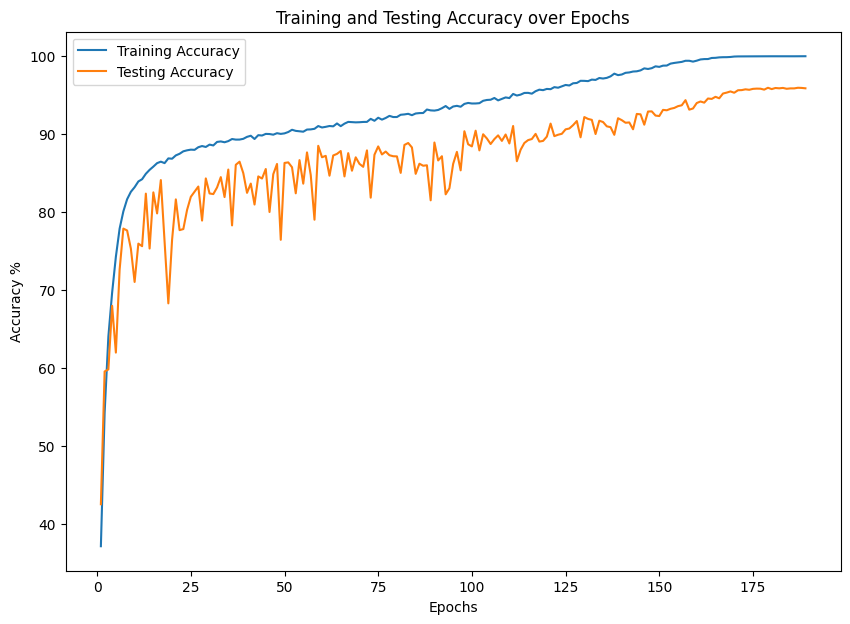

In [16]:
epochs = range(1, 190)  # since epoch counting starts at 0, we adjust the range to 1 through 200

# Plotting training and testing losses
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss_history, label='Training Loss')
plt.plot(epochs, test_loss_history, label='Testing Loss')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and testing accuracies
plt.figure(figsize=(10, 7))
plt.plot(epochs, 100*train_accuracy_history, label='Training Accuracy')
plt.plot(epochs, 100*test_accuracy_history, label='Testing Accuracy')
plt.title('Training and Testing Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy %')
plt.legend()
plt.show()